# Boxplot of top five up- and downregulated genes

In [1]:
library(ggplot2)
library(reshape2)

In [2]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv'
pheno = read.csv(pheno_file, row.names=1)
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R12864,Br1303,R12864,Caudate,9.6,42.98,F,AA,Schizo
R12865,Br1320,R12865,Caudate,9.5,53.12,M,AA,Schizo


## Load residualized expression

In [3]:
res_file = '../../_m/genes/residualized_expression.tsv'
resdf = t(read.delim(res_file, row.names=1))
resdf[1:2, 1:3]

,ENSG00000227232.5,ENSG00000278267.1,ENSG00000279457.3
R12864,-0.3612514,0.9621523,0.5156470
R12865,-1.1194240,0.2565440,-0.1181251


## Overall
### Differential expressed genes

In [4]:
genes = read.delim('../../_m/genes/diffExpr_maleVfemale_full.txt')
genes['Feature'] = row.names(genes)
genes = subset(genes, adj.P.Val < 0.05, 
               select=c(Feature, ensemblID, Symbol, logFC, adj.P.Val))
head(genes, 2)

,Feature,ensemblID,Symbol,logFC,adj.P.Val
,<chr>,<fct>,<fct>,<dbl>,<dbl>
ENSG00000229807.10,ENSG00000229807.10,ENSG00000229807,XIST,-9.379552,1.768011e-298
ENSG00000114374.12,ENSG00000114374.12,ENSG00000114374,USP9Y,8.802000,1.312109e-294


### Upregulated

In [5]:
up_genes = subset(genes, logFC > 0)
up_genes['Dir'] = 'Up'
sigUp_genes = head(up_genes, 5)
sigUp_genes = droplevels(sigUp_genes)

for(xx in seq_along(sigUp_genes$Symbol)){
    if(sigUp_genes$Symbol[xx] == ''){
        sigUp_genes$New_ID[xx] = paste0(sigUp_genes$ensemblID[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigUp_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigUp_genes$adj.P.Val[xx]))
    } else {
        sigUp_genes$New_ID[xx] = paste0(sigUp_genes$Symbol[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigUp_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigUp_genes$adj.P.Val[xx]))
    }
}

sigUp_genes$New_ID = as.factor(sigUp_genes$New_ID)
sigUp_genes$New_ID = with(sigUp_genes, reorder(New_ID, adj.P.Val, median))
sigUp_genes

,Feature,ensemblID,Symbol,logFC,adj.P.Val,Dir,New_ID
,<chr>,<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
ENSG00000114374.12,ENSG00000114374.12,ENSG00000114374,USP9Y,8.802000,1.312109e-294,Up,USP9Y logFC: 8.80 FDR: 1.31e-294
ENSG00000183878.15,ENSG00000183878.15,ENSG00000183878,UTY,8.711657,8.036156e-270,Up,UTY logFC: 8.71 FDR: 8.04e-270
ENSG00000012817.15,ENSG00000012817.15,ENSG00000012817,KDM5D,8.804598,4.899895e-265,Up,KDM5D logFC: 8.80 FDR: 4.90e-265
ENSG00000067048.16,ENSG00000067048.16,ENSG00000067048,DDX3Y,8.688252,1.752572e-264,Up,DDX3Y logFC: 8.69 FDR: 1.75e-264
ENSG00000067646.11,ENSG00000067646.11,ENSG00000067646,ZFY,8.625705,4.667242e-252,Up,ZFY logFC: 8.63 FDR: 4.67e-252


In [6]:
df1 = data.frame(resdf[, rownames(sigUp_genes)])
df1['RNum'] = row.names(df1)
df1 = melt(df1, id.vars="RNum", value.name = "res", variable.name="Feature")
head(df1, 2)

,RNum,Feature,res
,<chr>,<fct>,<dbl>
1,R12864,ENSG00000114374.12,-1.4244016
2,R12865,ENSG00000114374.12,0.6490539


In [7]:
df1 = merge(df1, sigUp_genes, by='Feature')
head(df1, 2)

,Feature,RNum,res,ensemblID,Symbol,logFC,adj.P.Val,Dir,New_ID
,<fct>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
1,ENSG00000012817.15,R12864,-1.3155797,ENSG00000012817,KDM5D,8.804598,4.899895e-265,Up,KDM5D logFC: 8.80 FDR: 4.90e-265
2,ENSG00000012817.15,R12865,0.6788621,ENSG00000012817,KDM5D,8.804598,4.899895e-265,Up,KDM5D logFC: 8.80 FDR: 4.90e-265


#### Merge data with phenotypes

In [8]:
bigdf1 = merge(pheno, df1, by='RNum')
levels(bigdf1$Sex) <- c("Female", "Male")
dim(bigdf1)

[1] 1950   16

#### Plot genes

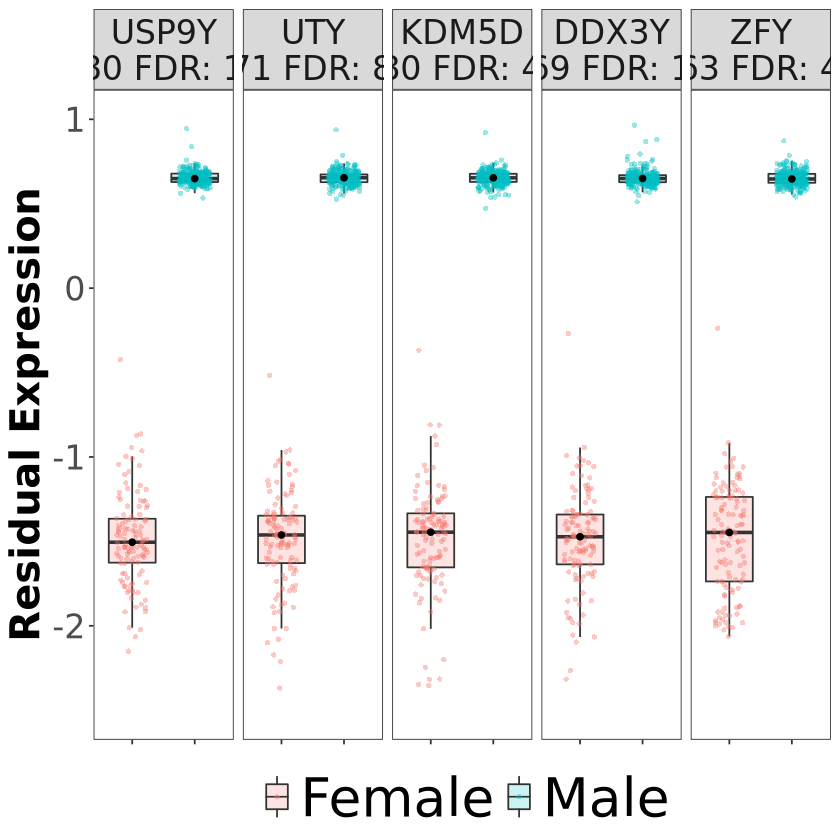

In [9]:
pjd = position_jitterdodge(jitter.width=1.0)
pp = (ggplot(bigdf1, aes(x=Sex, y=res, fill=Sex)) + geom_boxplot(alpha=0.2, outlier.alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4, aes(color=Sex)) + ylim(-2.5, 1) + 
      labs(x='Gender', y='Residual Expression') + facet_grid('Dir~New_ID') +
      stat_summary(geom='point', position='identity', fun.y=median, fill='black') + 
      theme_bw() + theme(axis.text.x=element_blank(), axis.text.y=element_text(size=20), 
                         axis.title.y=element_text(size=24, face='bold'), axis.title.x=element_blank(),
                         strip.text.x=element_text(size=20), strip.text.y=element_blank(), 
                         legend.text=element_text(size=32), legend.title=element_blank(), 
                         legend.position="bottom", panel.grid=element_blank()))
pp

In [10]:
ggsave(pp, filename = 'top5_upregulated_boxplot.pdf', width=20, height=8)
ggsave(pp, filename = 'top5_upregulated_boxplot.svg', width=20, height=8)
ggsave(pp, filename = 'top5_upregulated_boxplot.png', width=20, height=8)

### Downregulated

In [11]:
down_genes = subset(genes, logFC < 0)
down_genes['Dir'] = 'Down'
sigDown_genes = head(down_genes, 5)
sigDown_genes = droplevels(sigDown_genes)

for(xx in seq_along(sigDown_genes$Symbol)){
    if(sigDown_genes$Symbol[xx] == ''){
        sigDown_genes$New_ID[xx] = paste0(sigDown_genes$ensemblID[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigDown_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigDown_genes$adj.P.Val[xx]))
    } else {
        sigDown_genes$New_ID[xx] = paste0(sigDown_genes$Symbol[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigDown_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigDown_genes$adj.P.Val[xx]))
    }
}

sigDown_genes$New_ID = as.factor(sigDown_genes$New_ID)
sigDown_genes$New_ID = with(sigDown_genes, reorder(New_ID, adj.P.Val, median))
sigDown_genes

,Feature,ensemblID,Symbol,logFC,adj.P.Val,Dir,New_ID
,<chr>,<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
ENSG00000229807.10,ENSG00000229807.10,ENSG00000229807,XIST,-9.3795518,1.768011e-298,Down,XIST logFC: -9.38 FDR: 1.77e-298
ENSG00000005889.15,ENSG00000005889.15,ENSG00000005889,ZFX,-0.6379621,2.765693e-153,Down,ZFX logFC: -0.64 FDR: 2.77e-153
ENSG00000147050.14,ENSG00000147050.14,ENSG00000147050,KDM6A,-0.5335609,1.433490e-108,Down,KDM6A logFC: -0.53 FDR: 1.43e-108
ENSG00000126012.11,ENSG00000126012.11,ENSG00000126012,KDM5C,-0.4918274,1.326352e-103,Down,KDM5C logFC: -0.49 FDR: 1.33e-103
ENSG00000130021.13,ENSG00000130021.13,ENSG00000130021,PUDP,-0.6047831,3.115524e-91,Down,PUDP logFC: -0.60 FDR: 3.12e-91


In [12]:
df2 = data.frame(resdf[, rownames(sigDown_genes)])
df2['RNum'] = row.names(df2)
df2 = melt(df2, id.vars="RNum", value.name = "res", variable.name="Feature")
head(df2, 2)

,RNum,Feature,res
,<chr>,<fct>,<dbl>
1,R12864,ENSG00000229807.10,1.561865
2,R12865,ENSG00000229807.10,-1.221697


In [13]:
df2 = merge(df2, sigDown_genes, by='Feature')
head(df2, 2)

,Feature,RNum,res,ensemblID,Symbol,logFC,adj.P.Val,Dir,New_ID
,<fct>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
1,ENSG00000005889.15,R12864,2.3069495,ENSG00000005889,ZFX,-0.6379621,2.765693e-153,Down,ZFX logFC: -0.64 FDR: 2.77e-153
2,ENSG00000005889.15,R12865,-0.8387256,ENSG00000005889,ZFX,-0.6379621,2.765693e-153,Down,ZFX logFC: -0.64 FDR: 2.77e-153


#### Merge data with phenotypes

In [14]:
bigdf2 = merge(pheno, df2, by='RNum')
levels(bigdf2$Sex) <- c("Female", "Male")
dim(bigdf2)

[1] 1950   16

#### Plot genes

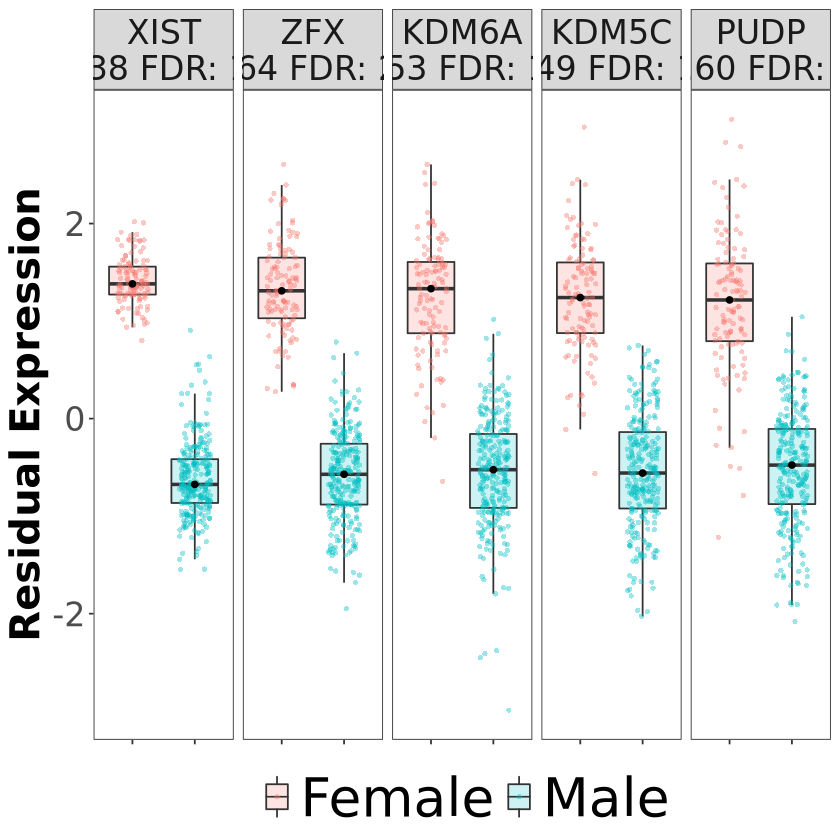

In [15]:
pjd = position_jitterdodge(jitter.width=1.0)
qq = (ggplot(bigdf2, aes(x=Sex, y=res, fill=Sex)) + geom_boxplot(alpha=0.2, outlier.alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4, aes(color=Sex)) + 
      labs(x='Diagnosis', y='Residual Expression') + facet_grid('Dir~New_ID') +
      stat_summary(geom='point', position='identity', fun.y=median, fill='black') + 
      theme_bw() + theme(axis.text.x=element_blank(), axis.text.y=element_text(size=20), 
                         axis.title.y=element_text(size=24, face='bold'), axis.title.x=element_blank(),
                         strip.text.x=element_text(size=20), strip.text.y=element_blank(), 
                         legend.text=element_text(size=32), legend.title=element_blank(), 
                         legend.position="bottom", panel.grid=element_blank()))
qq

In [16]:
ggsave(qq, filename = 'top5_downregulated_boxplot.pdf', width=20, height=8)
ggsave(qq, filename = 'top5_downregulated_boxplot.svg', width=20, height=8)
ggsave(qq, filename = 'top5_downregulated_boxplot.png', width=20, height=8)

## Autosomal only

### Differential expressed genes

In [17]:
genes = read.csv('../../metrics_summary/_m/autosomal_DEG.csv')
row.names(genes) <- genes$Feature
genes = genes[order(genes$adj.P.Val), ]
head(genes, 2)

,Feature,chr,Symbol,ensemblID,logFC,adj.P.Val,Type
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
ENSG00000205611.4,ENSG00000205611.4,chr20,LINC01597,ENSG00000205611,1.275462,9.876973e-19,gene
ENSG00000283443.1,ENSG00000283443.1,chr20,chr?,ENSG00000283443,1.384840,7.542470e-18,gene


### Upregulated

In [18]:
up_genes = subset(genes, logFC > 0)
up_genes['Dir'] = 'Up'
sigUp_genes = head(up_genes, 5)
sigUp_genes = droplevels(sigUp_genes)

for(xx in seq_along(sigUp_genes$Symbol)){
    if(sigUp_genes$Symbol[xx] == '' | sigUp_genes$Symbol[xx] == 'chr?'){
        sigUp_genes$New_ID[xx] = paste0(sigUp_genes$ensemblID[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigUp_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigUp_genes$adj.P.Val[xx]))
    } else {
        sigUp_genes$New_ID[xx] = paste0(sigUp_genes$Symbol[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigUp_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigUp_genes$adj.P.Val[xx]))
    }
}

sigUp_genes$New_ID = as.factor(sigUp_genes$New_ID)
sigUp_genes$New_ID = with(sigUp_genes, reorder(New_ID, adj.P.Val, median))
sigUp_genes

,Feature,chr,Symbol,ensemblID,logFC,adj.P.Val,Type,Dir,New_ID
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<fct>
ENSG00000205611.4,ENSG00000205611.4,chr20,LINC01597,ENSG00000205611,1.2754623,9.876973e-19,gene,Up,LINC01597 logFC: 1.28 FDR: 9.88e-19
ENSG00000283443.1,ENSG00000283443.1,chr20,chr?,ENSG00000283443,1.3848397,7.542470e-18,gene,Up,ENSG00000283443 logFC: 1.38 FDR: 7.54e-18
ENSG00000149531.15,ENSG00000149531.15,chr20,FRG1BP,ENSG00000149531,0.6626228,3.496520e-17,gene,Up,FRG1BP logFC: 0.66 FDR: 3.50e-17
ENSG00000282826.1,ENSG00000282826.1,chr20,FRG1CP,ENSG00000282826,0.5438468,7.505486e-15,gene,Up,FRG1CP logFC: 0.54 FDR: 7.51e-15
ENSG00000080007.7,ENSG00000080007.7,chr6,DDX43,ENSG00000080007,1.0370022,9.235694e-12,gene,Up,DDX43 logFC: 1.04 FDR: 9.24e-12


In [19]:
df1 = data.frame(resdf[, rownames(sigUp_genes)])
df1['RNum'] = row.names(df1)
df1 = melt(df1, id.vars="RNum", value.name = "res", variable.name="Feature")
head(df1, 2)

,RNum,Feature,res
,<chr>,<fct>,<dbl>
1,R12864,ENSG00000205611.4,-3.6848357
2,R12865,ENSG00000205611.4,0.9896649


In [20]:
df1 = merge(df1, sigUp_genes, by='Feature')
head(df1, 2)

,Feature,RNum,res,chr,Symbol,ensemblID,logFC,adj.P.Val,Type,Dir,New_ID
,<fct>,<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<fct>
1,ENSG00000080007.7,R12864,0.1585005,chr6,DDX43,ENSG00000080007,1.037002,9.235694e-12,gene,Up,DDX43 logFC: 1.04 FDR: 9.24e-12
2,ENSG00000080007.7,R12865,0.8589183,chr6,DDX43,ENSG00000080007,1.037002,9.235694e-12,gene,Up,DDX43 logFC: 1.04 FDR: 9.24e-12


#### Merge data with phenotypes

In [21]:
bigdf1 = merge(pheno, df1, by='RNum')
levels(bigdf1$Sex) <- c("Female", "Male")
dim(bigdf1)

[1] 1950   18

#### Plot genes

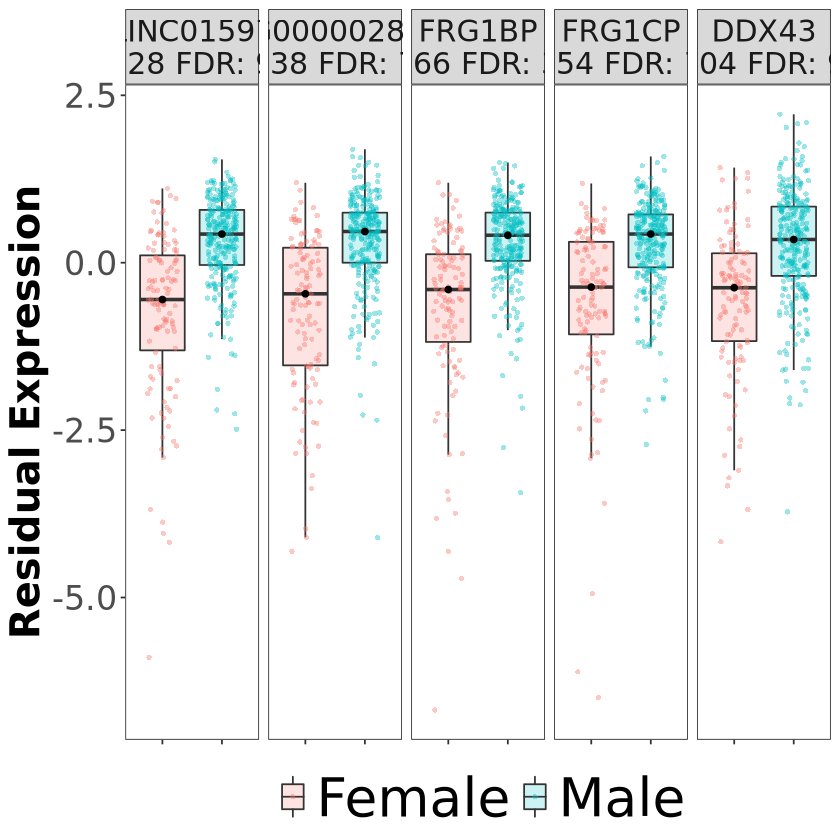

In [22]:
pjd = position_jitterdodge(jitter.width=1.0)
pp = (ggplot(bigdf1, aes(x=Sex, y=res, fill=Sex)) + geom_boxplot(alpha=0.2, outlier.alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4, aes(color=Sex)) + 
      labs(x='Gender', y='Residual Expression') + facet_grid('Dir~New_ID') +
      stat_summary(geom='point', position='identity', fun.y=median, fill='black') + 
      theme_bw() + theme(axis.text.x=element_blank(), axis.text.y=element_text(size=20), 
                         axis.title.y=element_text(size=24, face='bold'), axis.title.x=element_blank(),
                         strip.text.x=element_text(size=18), strip.text.y=element_blank(), 
                         legend.text=element_text(size=32), legend.title=element_blank(), 
                         legend.position="bottom", panel.grid=element_blank()))
pp

In [23]:
ggsave(pp, filename = 'top5_upregulated_boxplot_autosomal.pdf', width=20, height=10)
ggsave(pp, filename = 'top5_upregulated_boxplot_autosomal.svg', width=20, height=10)
ggsave(pp, filename = 'top5_upregulated_boxplot_autosomal.png', width=20, height=10)

### Downregulated

In [24]:
down_genes = subset(genes, logFC < 0)
down_genes['Dir'] = 'Down'
sigDown_genes = head(down_genes, 5)
sigDown_genes = droplevels(sigDown_genes)

for(xx in seq_along(sigDown_genes$Symbol)){
    if(sigDown_genes$Symbol[xx] == '' | sigDown_genes$Symbol[xx] == 'chr?'){
        sigDown_genes$New_ID[xx] = paste0(sigDown_genes$ensemblID[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigDown_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigDown_genes$adj.P.Val[xx]))
    } else {
        sigDown_genes$New_ID[xx] = paste0(sigDown_genes$Symbol[xx], '\nlogFC: ', 
                                sprintf("%.2f", sigDown_genes$logFC[xx]), ' FDR: ', 
                                sprintf("%.2e", sigDown_genes$adj.P.Val[xx]))
    }
}

sigDown_genes$New_ID = as.factor(sigDown_genes$New_ID)
sigDown_genes$New_ID = with(sigDown_genes, reorder(New_ID, adj.P.Val, median))
sigDown_genes

,Feature,chr,Symbol,ensemblID,logFC,adj.P.Val,Type,Dir,New_ID
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<fct>
ENSG00000095932.6,ENSG00000095932.6,chr19,SMIM24,ENSG00000095932,-0.8827318,1.815017e-15,gene,Down,SMIM24 logFC: -0.88 FDR: 1.82e-15
ENSG00000236698.1,ENSG00000236698.1,chr1,EIF1AXP1,ENSG00000236698,-0.2585955,1.328284e-13,gene,Down,EIF1AXP1 logFC: -0.26 FDR: 1.33e-13
ENSG00000261600.1,ENSG00000261600.1,chr2,chr?,ENSG00000261600,-0.9768706,1.846380e-13,gene,Down,ENSG00000261600 logFC: -0.98 FDR: 1.85e-13
ENSG00000180574.3,ENSG00000180574.3,chr12,chr?,ENSG00000180574,-0.2409642,1.600278e-11,gene,Down,ENSG00000180574 logFC: -0.24 FDR: 1.60e-11
ENSG00000241532.1,ENSG00000241532.1,chr3,AGGF1P3,ENSG00000241532,-0.7239031,6.363821e-11,gene,Down,AGGF1P3 logFC: -0.72 FDR: 6.36e-11


In [25]:
df2 = data.frame(resdf[, rownames(sigDown_genes)])
df2['RNum'] = row.names(df2)
df2 = melt(df2, id.vars="RNum", value.name = "res", variable.name="Feature")
head(df2, 2)

,RNum,Feature,res
,<chr>,<fct>,<dbl>
1,R12864,ENSG00000095932.6,1.1096723
2,R12865,ENSG00000095932.6,-0.5409693


In [26]:
df2 = merge(df2, sigDown_genes, by='Feature')
head(df2, 2)

,Feature,RNum,res,chr,Symbol,ensemblID,logFC,adj.P.Val,Type,Dir,New_ID
,<fct>,<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<fct>
1,ENSG00000095932.6,R12864,1.1096723,chr19,SMIM24,ENSG00000095932,-0.8827318,1.815017e-15,gene,Down,SMIM24 logFC: -0.88 FDR: 1.82e-15
2,ENSG00000095932.6,R12865,-0.5409693,chr19,SMIM24,ENSG00000095932,-0.8827318,1.815017e-15,gene,Down,SMIM24 logFC: -0.88 FDR: 1.82e-15


#### Merge data with phenotypes

In [27]:
bigdf2 = merge(pheno, df2, by='RNum')
levels(bigdf2$Sex) <- c("Female", "Male")
dim(bigdf2)

[1] 1950   18

#### Plot genes

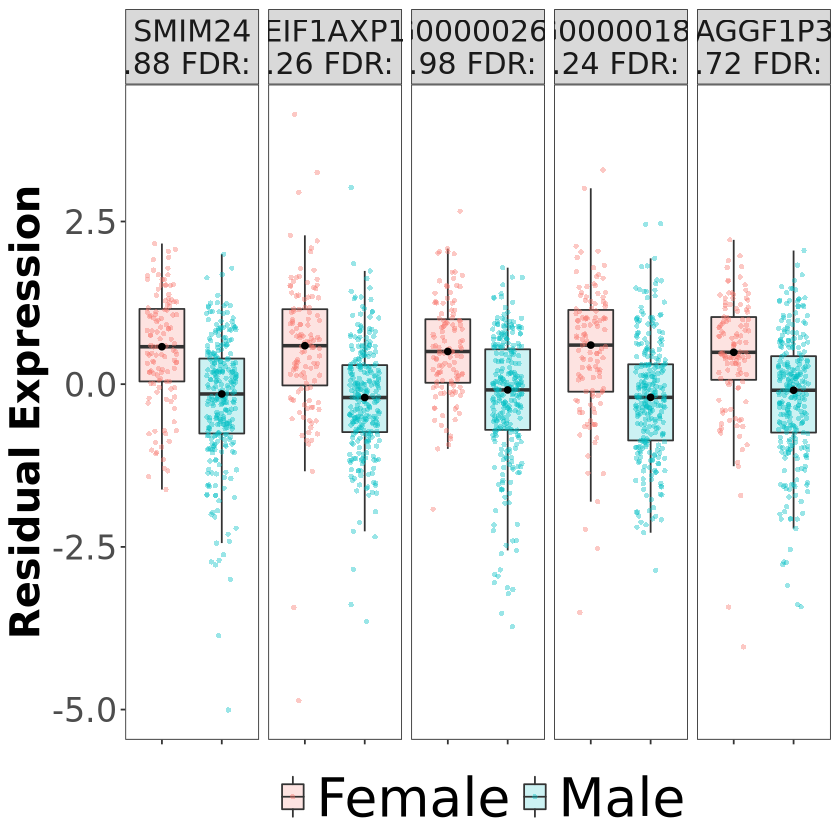

In [28]:
pjd = position_jitterdodge(jitter.width=1.0)
qq = (ggplot(bigdf2, aes(x=Sex, y=res, fill=Sex)) + geom_boxplot(alpha=0.2, outlier.alpha=0) + 
      geom_jitter(position=pjd, stroke=0, alpha=0.4, aes(color=Sex)) + 
      labs(x='Diagnosis', y='Residual Expression') + facet_grid('Dir~New_ID') +
      stat_summary(geom='point', position='identity', fun.y=median, fill='black') + 
      theme_bw() + theme(axis.text.x=element_blank(), axis.text.y=element_text(size=20), 
                         axis.title.y=element_text(size=24, face='bold'), axis.title.x=element_blank(),
                         strip.text.x=element_text(size=18), strip.text.y=element_blank(), 
                         legend.text=element_text(size=32), legend.title=element_blank(), 
                         legend.position="bottom", panel.grid=element_blank()))
qq

In [29]:
ggsave(qq, filename = 'top5_downregulated_boxplot_autosomal.pdf', width=20, height=10)
ggsave(qq, filename = 'top5_downregulated_boxplot_autosomal.svg', width=20, height=10)
ggsave(qq, filename = 'top5_downregulated_boxplot_autosomal.png', width=20, height=10)

## Session Info

In [30]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2020-02-24 21:52:05 EST"

   user  system elapsed 
 54.234   1.439  59.113 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 3.6.2 (2019-12-12)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2020-02-24                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version date       lib source        
 assertthat    0.2.1   2019-03-21 [1] CRAN (R 3.6.1)
 base64enc     0.1-3   2015-07-28 [1] CRAN (R 3.6.1)
 cli           2.0.1   2020-01-08 [1] CRAN (R 3.6.2)
 colorspace    1.4-1   2019-03-18 [1] CRAN (R 3.6.1)
 crayon        1.3.4   2017-09-16 [1] CRAN (R 3.6.1)
 digest        0.6.24  2020-02-12 [1] CRAN (R 3.6.2)
